**Angie Carolina Joya Duarte - 2322609**  

**Sheila Marcela Valencia Chito - 2243011**

# Entrega 2 - RNN

Se escogió para este trabajo el dataset "Twitter US Airline Sentiment"

## Importación y análisis del dataset

Importamos las librerías

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
import nltk

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample, class_weight

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

c:\Python312\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.stats import gaussian_kde


Definimos las funciones auxiliares para graficar

In [5]:
def graficaDistribucion (dataset, atributo, etiquetas, ejeX, ejeY, titulo):
    graphOutput = sns.countplot(x=atributo, hue=atributo, data=dataset, palette="Set2", legend=False)
    total = len(dataset)

    for p in graphOutput.patches:
        count = p.get_height() #frecuencia absoluta
        percent = 100 * count / total #frecuencia relativa

        graphOutput.annotate(f'{percent:.1f}%', # formato de texto
            (p.get_x() + p.get_width() / 2., count/2),  #posición
            ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points')

    ticks = graphOutput.get_xticks()
    graphOutput.set_xticks(ticks)
    graphOutput.set_xticklabels(etiquetas)
    graphOutput.set_xlabel(ejeX)
    graphOutput.set_ylabel(ejeY)
    graphOutput.set_title(titulo)

    plt.show()

In [6]:
def graficaEntrenamiento(resultado, set1, set2, titulo, ylabel):
    plt.plot(resultado.history[set1], label="Entrenamiento")
    plt.plot(resultado.history[set2], label="Validación")
    plt.title(titulo)
    plt.xlabel("Época")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [7]:
def graficaMatriz(yTest_labels, yPred_labels):
  # Matriz de confusión
  cm = confusion_matrix(yTest_labels, yPred_labels)
  class_names = ['Negativo', 'Neutro', 'Positivo']

  # Graficar
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Matriz de Confusión")

  plt.xlabel("Predicción")
  plt.ylabel("Etiqueta real")

  plt.show()

Importamos el dataset y lo almacenamos como un dataframe de pandas. Verificamos que no hayan datos faltantes y revisamos la distribución porcentual de los datos para verificar si el conjunto sea representativo


In [8]:
path = os.path.join(os.getcwd(), "Tweets.csv")
dataset = pd.read_csv(path, usecols=[1, 5, 10])
dataset.info()
print("\nAerolíneas:", dataset.airline.unique())
print("Opiniones:", dataset.airline_sentiment.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   text               14640 non-null  object
dtypes: object(3)
memory usage: 343.3+ KB

Aerolíneas: ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
Opiniones: ['neutral' 'positive' 'negative']


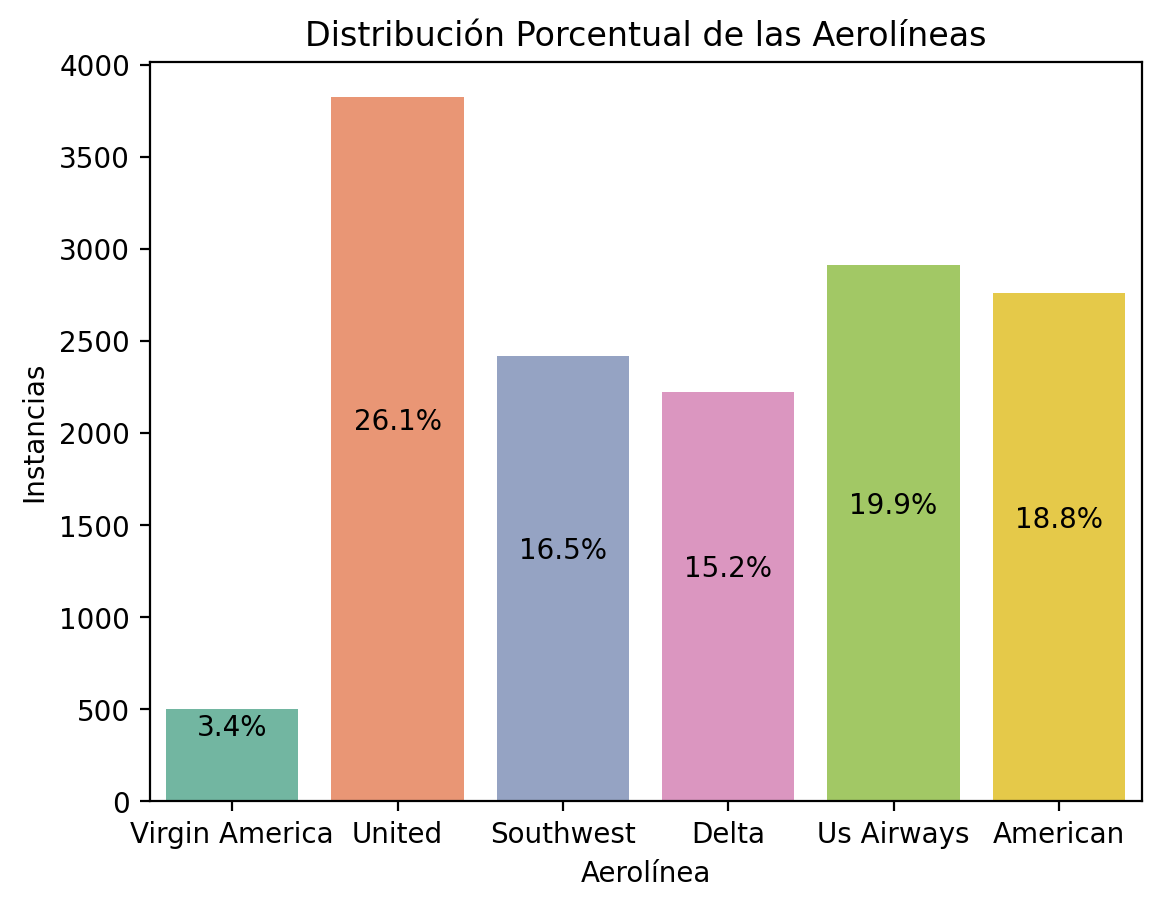

In [9]:
graficaDistribucion(dataset,"airline",["Virgin America", "United", "Southwest", "Delta", "Us Airways", "American"],"Aerolínea","Instancias","Distribución Porcentual de las Aerolíneas")

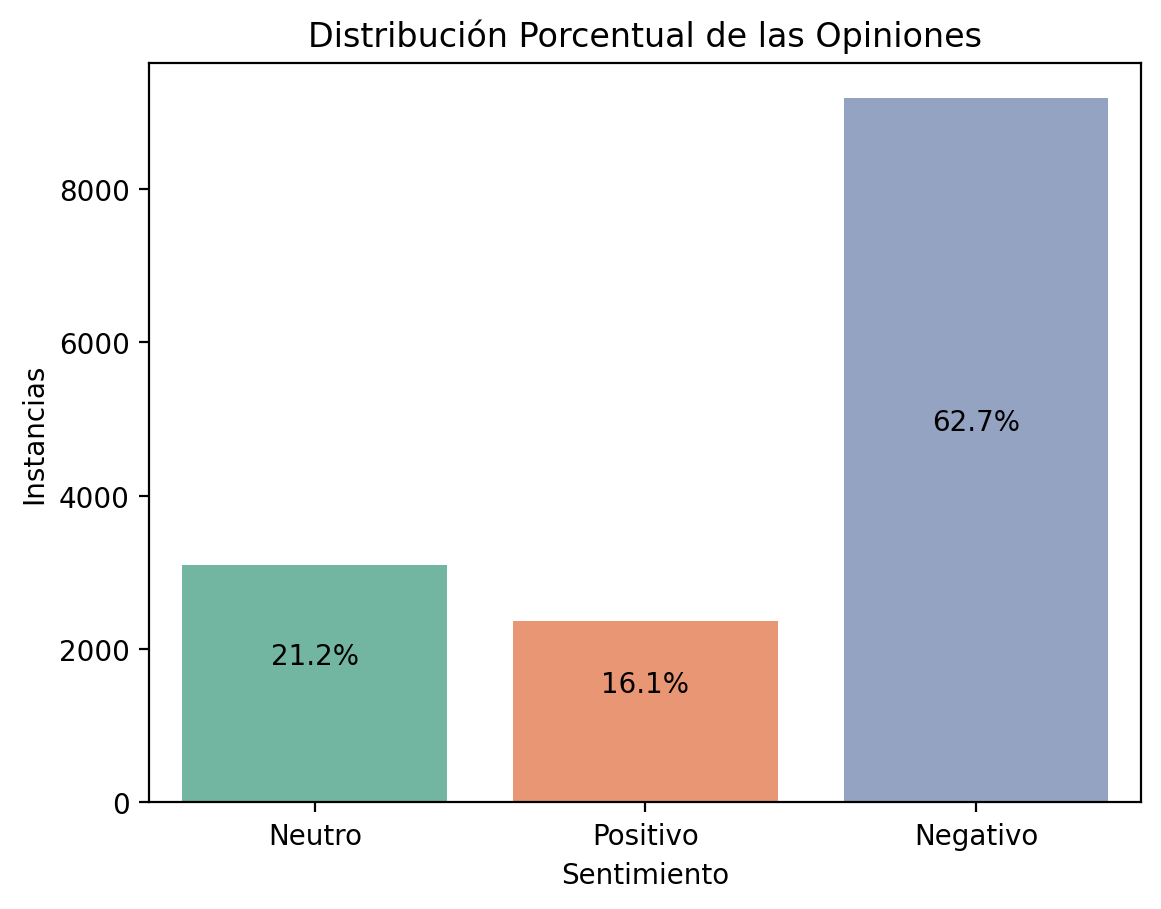

In [10]:
graficaDistribucion(dataset,"airline_sentiment",["Neutro", "Positivo", "Negativo"],"Sentimiento","Instancias","Distribución Porcentual de las Opiniones")

Hay un desbalanceo en las opiniones, la opinión positiva tiene el 62.7% y la negativa tiene el 16.1%, así que se implementarán técnicas de muestreo para balancear los datos.

## Preprocesamiento de los datos

Representamos las opiniones con etiquetas de enteros: 0 para negativa, 1 para neutral y 2 para positiva

In [11]:
dataset = dataset.drop(["airline"], axis=1)
dataset["sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)
dataset = dataset.drop(["airline_sentiment"], axis=1)

C:\Users\sheil\AppData\Local\Temp\ipykernel_18188\2424373769.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)


Procesamos y tokenizamos el texto para poder asignarle representaciones numéricas que se puedan utilizar en la Red Neuronal

In [12]:
nltk.download('stopwords')
palVacias = set(stopwords.words('english'))
palRaiz = SnowballStemmer('english')
tokenizador = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")

#Además de stopwords, también eliminamos tags (@), links, y el # de los hashtags
usuarios = r"@\w*"
hashtags = r"#(\w+)"
links = r"http\S+"

#Los verbos conjugados en negación no reemplazan por "not" y no se eliminan
negaciones = r"\b(\w+)n't\b"

def preprocesamiento (tweet, stem=True):
    tweet = re.sub(usuarios, "", tweet)
    tweet = re.sub(hashtags, r"\1", tweet)
    tweet = re.sub(links, "", tweet)
    tweet = re.sub(negaciones, "not", tweet, flags=re.IGNORECASE)

    palabras = tokenizador.tokenize(tweet)
    texto = []

    #Convertimos el texto en un vector de palabras
    for palabra in palabras:
        palabra_lower = palabra.lower()
        # Conserva "no" y "not" aunque sean stopwords
        if palabra_lower == "not" or palabra_lower == "no" or palabra_lower not in palVacias:
            #Convertir verbos conjugados a su raíz
            if stem:
                texto.append(palRaiz.stem(palabra).lower())
            else:
                texto.append(palabra_lower)

    return " ".join(texto)

#Aplicar preprocesamiento a todo el dataset
dataset["token"] = dataset.text.map(preprocesamiento)

dataset.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,sentiment,token
0,@VirginAmerica What @dhepburn said.,1,said
1,@VirginAmerica plus you've added commercials t...,2,plus ad commerci experi tacki
2,@VirginAmerica I didn't today... Must mean I n...,1,not today must mean need take anoth trip
3,@VirginAmerica it's really aggressive to blast...,0,realli aggress blast obnoxi entertain guest fa...
4,@VirginAmerica and it's a really big bad thing...,0,realli big bad thing


La técnica de submuestreo Near Miss Centroids solo funciona cuando los datos a procesar son numéricos. Debido a que tenemos texto en su lugar, implementamos otras técnicas para balancear el dataset. En este caso, Submuestreo Leve y Weighted Loss

In [13]:
#Submuestreo del 70% de la clase mayoritaria (negativo)

instancias = dataset.sentiment.value_counts()
print("Dataset original: ", instancias)

subNegativas = int(instancias[0]*1)

dfNegativo = dataset[dataset.sentiment == 0]
dfOtras = dataset[dataset.sentiment != 0]

submuestreo = resample(
  dfNegativo,
  replace=False,
  n_samples=subNegativas,
  random_state=42
)

datasetBal = pd.concat([submuestreo, dfOtras]).sample(frac=1).reset_index(drop=True)
datasetBal = datasetBal.sample(frac=1, random_state=42).reset_index(drop=True)
print("Dataset con submuestreo: ", datasetBal.sentiment.value_counts())

Dataset original:  sentiment
0    9178
1    3099
2    2363
Name: count, dtype: int64
Dataset con submuestreo:  sentiment
0    9178
1    3099
2    2363
Name: count, dtype: int64


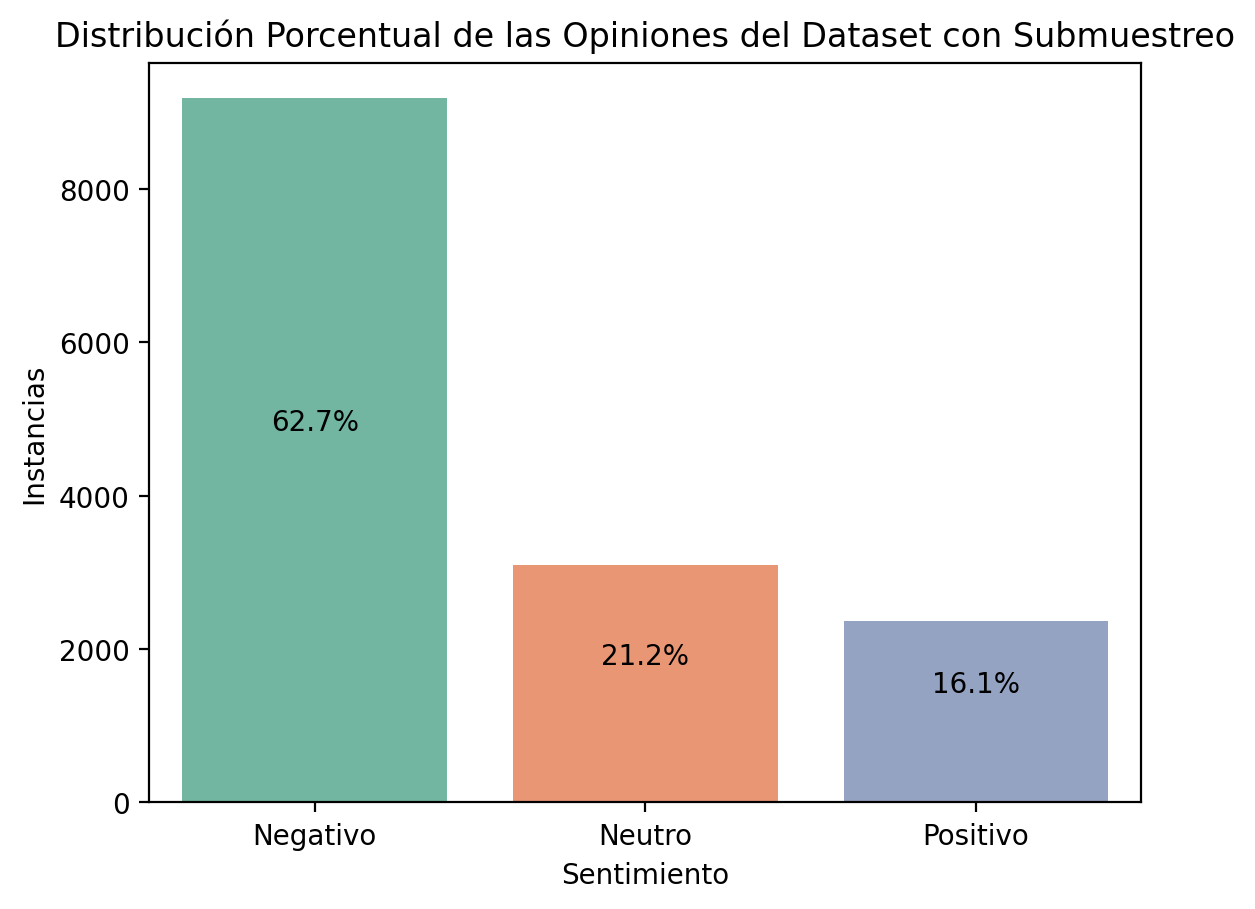

In [14]:
graficaDistribucion(datasetBal,"sentiment",["Negativo", "Neutro", "Positivo"],"Sentimiento","Instancias","Distribución Porcentual de las Opiniones del Dataset con Submuestreo")

El algoritmo TF-IDF no conserva el orden de las palabras, lo que es importante para las Redes Neuronales Recurrentes. Así que se usará el tokenizador de Keras para darle un valor numérico al texto preprocesado

In [15]:
#Tokenizar el texto preprocesado
tokenizerKeras = Tokenizer(num_words=2000, oov_token="<OOV>")
tokenizerKeras.fit_on_texts(datasetBal["token"])

datasetBal["repTemporal"] = tokenizerKeras.texts_to_sequences(datasetBal["token"])

datasetBal.head()

,text,sentiment,token,repTemporal
0,"@AmericanAir Yo, could that be a catering truc...",1,yo could cater truck mine eye unmov,"[1213, 96, 856, 1578, 709, 1214, 1]"
1,@united 6377 and now they sent our green tagge...,0,6377 sent green tag bag luggag carousel one me...,"[1, 133, 1968, 710, 16, 90, 1157, 25, 527, 83,..."
2,@SouthwestAir thank you for the response. How ...,1,thank respons got get point onto reward account,"[4, 105, 39, 5, 195, 893, 768, 303]"
3,@AmericanAir you should be contacting her for ...,1,contact refund dm provid phone number,"[214, 139, 94, 290, 41, 93]"
4,@AmericanAir can I get a free ticket to Hawaii...,1,get free ticket hawaii fabul,"[5, 203, 50, 1098, 1579]"


In [16]:
X = pad_sequences(datasetBal["repTemporal"], maxlen=max(len(seq) for seq in datasetBal["repTemporal"]), padding='post')
datasetBal["rep"] = list(X)
datasetBal = datasetBal.drop(columns=["repTemporal"])

datasetBal.head()

,text,sentiment,token,rep
0,"@AmericanAir Yo, could that be a catering truc...",1,yo could cater truck mine eye unmov,"[1213, 96, 856, 1578, 709, 1214, 1, 0, 0, 0, 0..."
1,@united 6377 and now they sent our green tagge...,0,6377 sent green tag bag luggag carousel one me...,"[1, 133, 1968, 710, 16, 90, 1157, 25, 527, 83,..."
2,@SouthwestAir thank you for the response. How ...,1,thank respons got get point onto reward account,"[4, 105, 39, 5, 195, 893, 768, 303, 0, 0, 0, 0..."
3,@AmericanAir you should be contacting her for ...,1,contact refund dm provid phone number,"[214, 139, 94, 290, 41, 93, 0, 0, 0, 0, 0, 0, ..."
4,@AmericanAir can I get a free ticket to Hawaii...,1,get free ticket hawaii fabul,"[5, 203, 50, 1098, 1579, 0, 0, 0, 0, 0, 0, 0, ..."


Luego de realizar el submuestreo podemos convertir la salidas en vectores de binarios usando one hot encoding

In [17]:
datasetBal["one_hot"] = list(to_categorical(datasetBal["sentiment"], num_classes=3))

## RNN Vainilla

### Definir los conjuntos de entrenamiento y prueba

70% para entrenamiento, 15% para validación y 15% para pruebas

In [18]:
n = len(datasetBal["rep"])

xTrain = np.array(datasetBal[:int(n*0.7)]["rep"].to_list(), dtype="int32")
xVal = np.array(datasetBal[int(n*0.7):int(n*0.85)]["rep"].to_list(), dtype="int32")
xTest = np.array(datasetBal[int(n*0.85):]["rep"].to_list(), dtype="int32")

yTrain = np.array(datasetBal[:int(n*0.7)]["one_hot"].tolist(), dtype="float32")
yVal = np.array(datasetBal[int(n*0.7):int(n*0.85)]["one_hot"].tolist(), dtype="float32")
yTest = np.array(datasetBal[int(n*0.85):]["one_hot"].tolist(), dtype="float32")

print("Tamaño conjunto de entrenamiento: ",len(xTrain))
print("Tamaño conjunto de validación: ",len(xVal))
print("Tamaño conjunto de prueba: ",len(xTest))

Tamaño conjunto de entrenamiento:  10248
Tamaño conjunto de validación:  2196
Tamaño conjunto de prueba:  2196


Calcular los class weights

In [19]:
class_weights = class_weight.compute_class_weight(
  class_weight='balanced',
  classes=np.unique(datasetBal["sentiment"]),
  y=datasetBal["sentiment"]
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.5317062540858575), 1: np.float64(1.5747015166182639), 2: np.float64(2.0651713922979265)}


Definir la arquitectura de la RNN

In [ ]:
def RNN (entrada, salida, sizeEmbedding):
    modelo = keras.Sequential([
        layers.Embedding(
            input_dim=2000,     # Debe coincidir con tu tokenizer num_words
            output_dim=sizeEmbedding,     # Tamaño del vector por palabra
            input_length=entrada,
        ),        
        layers.Bidirectional(layers.SimpleRNN(
            64,
            activation="tanh",
            kernel_regularizer=regularizers.l2(0.0001),
            return_sequences=True,
            recurrent_dropout=0,
            dropout = 0.3
        )),        
        layers.SimpleRNN(
            32,
            activation="tanh",
            kernel_regularizer=regularizers.l2(0.001),
            return_sequences=True,
            recurrent_dropout=0,
            dropout = 0.2
        ),  
        layers.SimpleRNN(
            16,
            activation="tanh",
            kernel_regularizer=regularizers.l2(0.0001),
            return_sequences=False,
            recurrent_dropout=0
        ),        
        layers.Dense(salida, activation="softmax")
    ])
    opt = Adam(learning_rate=0.00001)
    modelo.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return modelo

Entrenar la RNN con class weights

In [99]:
def entrenamiento (xTrain, yTrain, xVal, yVal, xTest, yTest, modelo, epocas, lote, class_weights, es):
  callbacks = []
  
  if es: 
    callbacks.append(
      keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
    )
        
  history = modelo.fit(
    xTrain, 
    yTrain, 
    validation_data=(xVal, yVal),
    epochs=epocas,
    batch_size=lote,
    class_weight=class_weights,
    verbose = 1,
    callbacks=callbacks,
  )
  
  loss, acc = modelo.evaluate(xTest, yTest, verbose=0)
  print(f"Accuracy de pruebas: {acc:.4f}")
  
  return history


In [100]:
epocas = 200
lote = 32
entrada =  xTrain.shape[1]
salida = yTrain.shape[1]

print("Tamaño de la entrada:",entrada)
print("Tamaño de la salida:",salida)

Tamaño de la entrada: 25
Tamaño de la salida: 3


In [101]:
modelo = RNN(entrada, salida, 164)
resultado = entrenamiento(xTrain, yTrain, xVal, yVal, xTest, yTest, modelo, epocas, lote, class_weights, True)

resultados = {
  "Época": ["Primera", "Última"],
  "Loss": [resultado.history["loss"][0], resultado.history["loss"][-1]],
  "Val_Loss": [resultado.history["val_loss"][0], resultado.history["val_loss"][-1]],
  "Accuracy": [resultado.history["accuracy"][0], resultado.history["accuracy"][-1]],
  "Val_Accuracy": [resultado.history["val_accuracy"][0], resultado.history["val_accuracy"][-1]],
}

tabla = pd.DataFrame(resultados)
print(tabla)

Epoch 1/200


c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


321/321 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.2807 - loss: 1.2494 - val_accuracy: 0.2741 - val_loss: 1.2410
Epoch 2/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.3350 - loss: 1.1936 - val_accuracy: 0.3301 - val_loss: 1.1891
Epoch 3/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.3984 - loss: 1.1593 - val_accuracy: 0.4098 - val_loss: 1.1442
Epoch 4/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.4371 - loss: 1.1369 - val_accuracy: 0.4740 - val_loss: 1.1070
Epoch 5/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.4967 - loss: 1.1070 - val_accuracy: 0.5223 - val_loss: 1.0527
Epoch 6/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.5271 - loss: 1.0830 - val_accuracy: 0.5524 - val_loss: 1.0200
Epoch 7/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.5680 - loss: 1.0486 - val_accuracy: 0.5943 - val_loss: 0.9629
Epoch 8/200
321/321 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5916 - loss: 1.0189 - val_

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


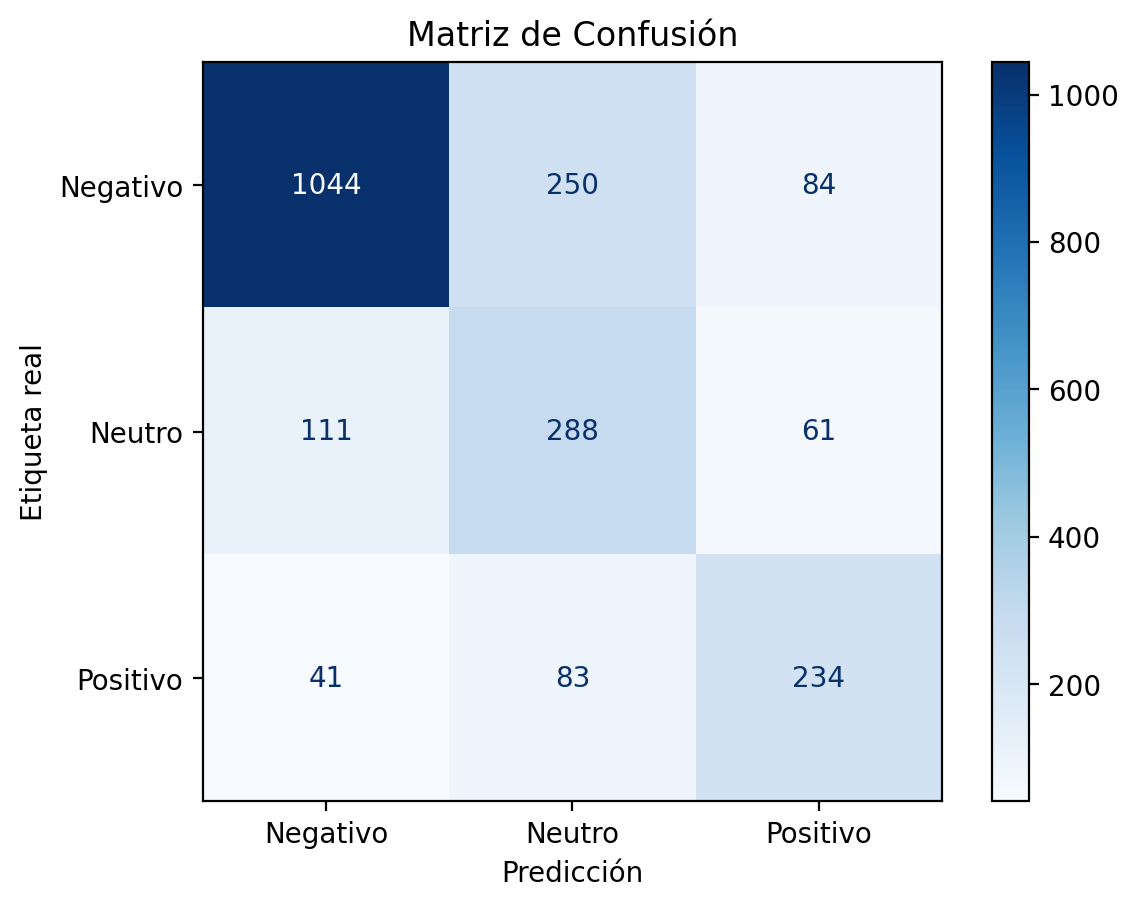

In [102]:
yPred = modelo.predict(xTest)
yPred_labels = np.argmax(yPred, axis=1)
yTest_labels = np.argmax(yTest, axis=1)

graficaMatriz(yTest_labels, yPred_labels)

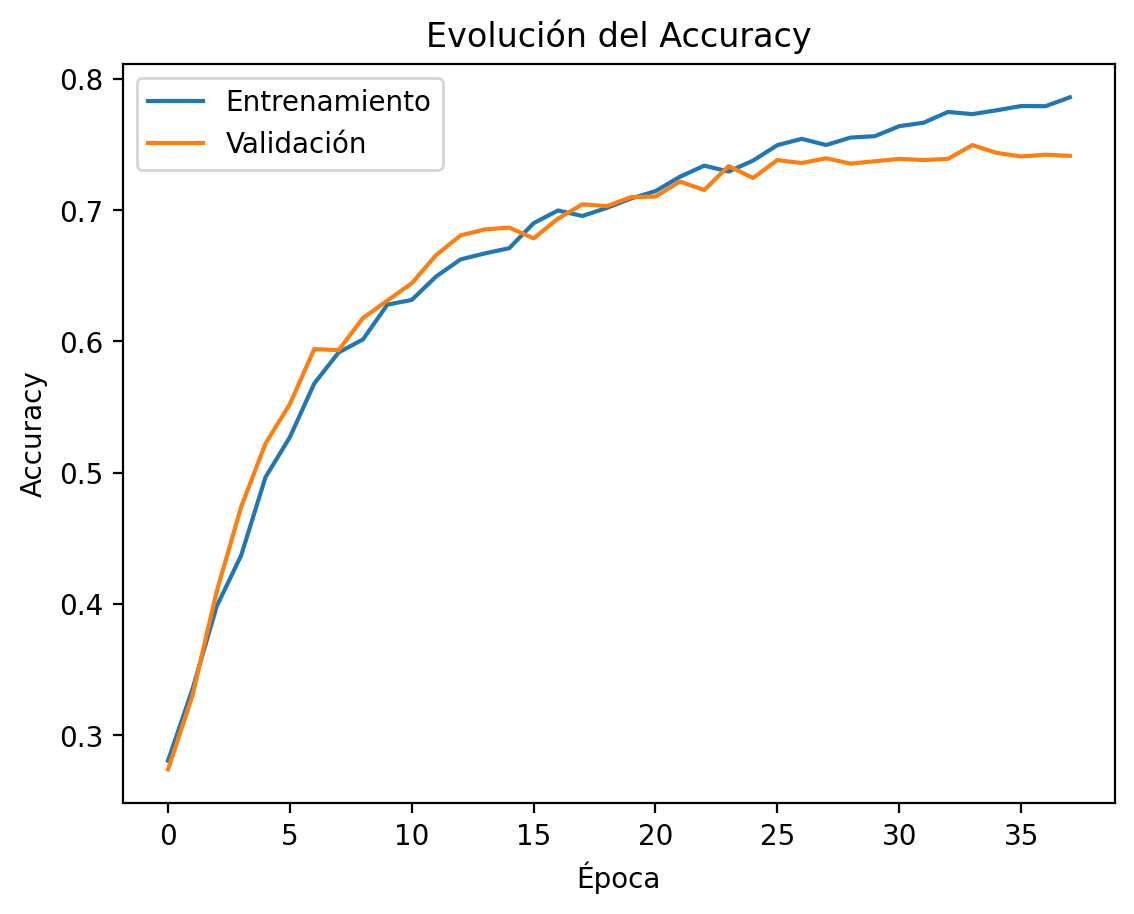

In [103]:
graficaEntrenamiento(resultado, "accuracy", "val_accuracy", "Evolución del Accuracy", "Accuracy")

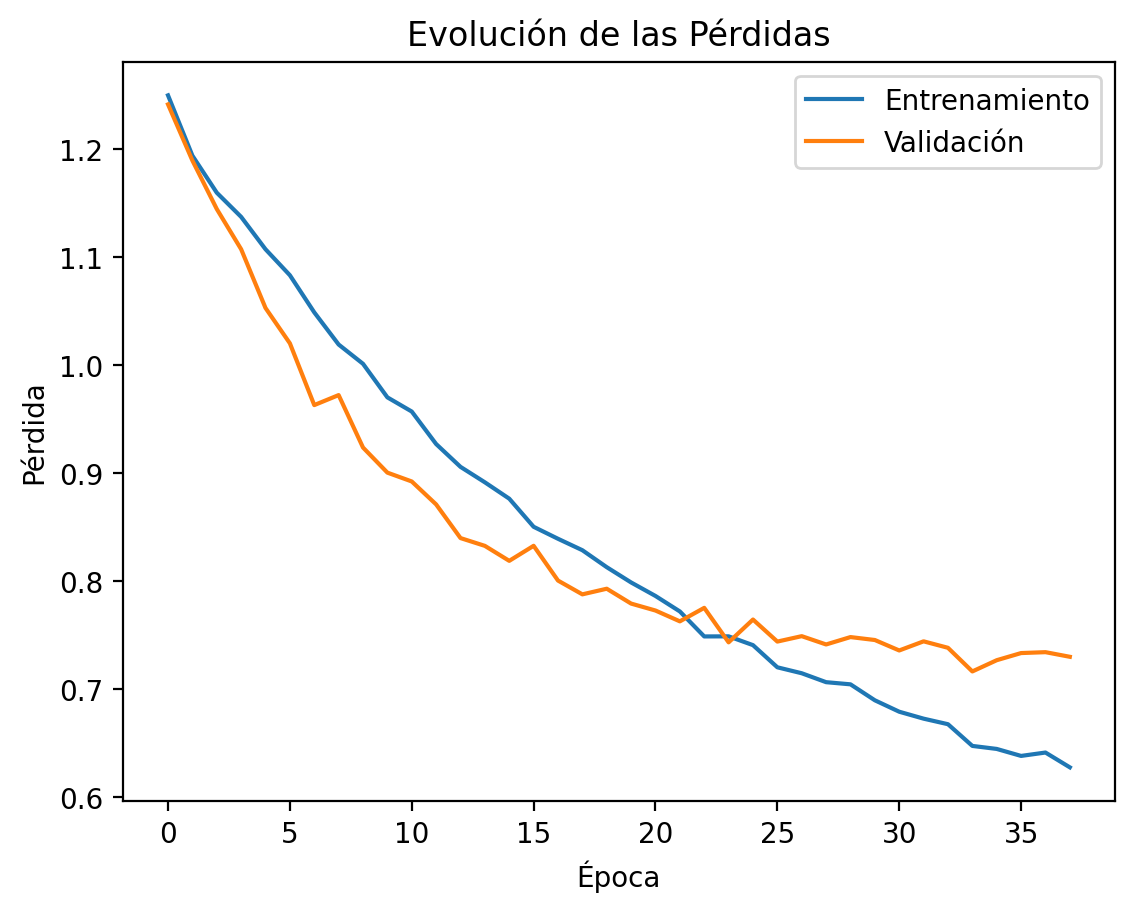

In [104]:
graficaEntrenamiento(resultado, "loss", "val_loss", "Evolución de las Pérdidas", "Pérdida")